In [1]:
#! /sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/bin/python
#SBATCH --partition=compute
#SBATCH --account=bb1153
#SBATCH --nodes=1
#SBATCH --time=08:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=%x.%j.log

import os
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import numpy as np
import xarray as xr
from scipy.interpolate import NearestNDInterpolator
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import postprocessing as pp

def interpolate_field_lon_lat(field, lon_coord="lon", lat_coord="lat", relative_resolution=1.5):
    """
    Interpolates a field on lon-lat grid to a higher resolution grid.
    
    Args:   
    - field: xarray DataArray containing the field to be interpolated.
    - lon_coord: Name of the longitude coordinate in the field.
    - lat_coord: Name of the latitude coordinate in the field.
    - relative_resolution: Relative resolution for the interpolation.

    Returns:
    - Interpolated field as an xarray DataArray.
    """
    # courtesy of marius winkler
    nlon = nlat = int(np.sqrt(len(field) * relative_resolution))  # maybe make this more configurable

    lon_points = field[lon_coord].values
    lat_points = field[lat_coord].values

    lon = np.linspace(np.min(lon_points), np.max(lon_points), nlon)
    lat = np.linspace(np.min(lat_points), np.max(lat_points), nlat)
    lon2, lat2 = np.meshgrid(lon, lat)

    points = np.stack((lon_points, lat_points), axis=1)
    return xr.DataArray(
        NearestNDInterpolator(points, field.values)(lon2, lat2),
        dims=["lat", "lon"],
        coords={"lon": lon, "lat": lat})

def load_control_surface(domain='DOM01'):
    """
    Loads control surface data for a specified domain.

    Args:
    - domain: Domain identifier.

    Returns:
    - Merged xarray dataset containing control surface data.
    """
    data = xr.open_zarr(f"https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/EUREC4A_LES/experiment_2/ICON_{domain}_surface.zarr")
    grid = xr.open_zarr(f"https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/grids/EUREC4A_PR1250m_{domain}.zarr")
    return xr.merge([data,grid]).drop_vars(list(grid)).drop_dims(['edge','vertex']).rename({'clon':'lon', 'clat':'lat'})

def grid_path(domain='DOM01'):
    """
    Returns the file path for the grid of a specified domain.

    Args:
    - domain: Domain identifier.

    Returns:
    - File path for the grid of the specified domain.
    """
    return f'/work/mh1126/m300872/unchanged/grids/EUREC4A_PR1250m_{domain}.nc'

def filelist(path, mask):
    """
    Creates a list of file paths based on the given path and mask.

    Args:
    - path: Directory path.
    - mask: String to filter files.

    Returns:
    - List of file paths.
    """
    return [os.path.join(path, f) for f in os.listdir(path) if mask in f]

# def load_rhofix_surface(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_spinup', domain='DOM01'):
def load_rhofix_surface(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05', domain='DOM01'):
    """
    Loads 'rho-fixed' surface data for a specified domain.

    Args:
    - exp_dir: Experiment directory path.
    - domain: Domain identifier.

    Returns:
    - Merged xarray dataset containing 'rho-fixed' surface data.
    """
    data = xr.open_mfdataset(filelist(exp_dir, 'DOM01_surface_'))
    data = data.rename({'ncells':'cell'})
    data = pp.replace_icon2datetime(data)
    grid = xr.open_dataset(grid_path())
    data = xr.merge([data,grid]).drop_vars(list(grid)).drop_dims(['edge','vertex']).rename({'clon':'lon', 'clat':'lat'})
    data = data.isel({'height':0, 'height_2':0}).drop(['height','height_2'])
    return data

def ax_imshow_field(ax, data, q=0.05, vmin=None, vmax=None):
    """
    Plots an interpolated field on an Axes object using imshow.

    Args:
    - ax: Matplotlib Axes object.
    - data: Field data as an xarray dataset.
    - q: Quantile value for data range (default: 0.05).
    - vmin: Minimum value for color scale (default: None).
    - vmax: Maximum value for color scale (default: None).

    Returns:
    - Updated Axes object.
    """
    if vmin == None: vmin = np.nanquantile(data, q)
    if vmax == None: vmax = np.nanquantile(data, 1.0-q)
    extent = [np.rad2deg(x) for x in [np.nanmin(data['lon'].values), np.nanmax(data['lon'].values), np.nanmin(data['lat'].values), np.nanmax(data['lat'].values)]]
    image = ax.imshow(interpolate_field_lon_lat(data), extent=extent, vmin=vmin, vmax=vmax)
    ax.invert_yaxis()
    return ax

def ax_contour_field(ax, data, relative_resolution=0.0005, levels=np.linspace(1000,1025,26)):
    """
    Plots contour lines of a field on an Axes object.

    Args:
    - ax: Matplotlib Axes object.
    - data: Field data as an xarray dataset.
    - relative_resolution: Relative resolution for interpolation (default: 0.0005).
    - levels: Contour levels (default: np.linspace(1000,1025,26)).

    Returns:
    - Updated Axes object.
    """
    def fmt(x): return f"{x:.0f} hPa"
    z = interpolate_field_lon_lat(data, relative_resolution=relative_resolution)
    x = np.rad2deg(z['lon'].values)
    y = np.flip(np.rad2deg(z['lat'].values))
    contour_plot = ax.contour(x,y,z, levels=levels, colors='black')
    ax.clabel(contour_plot, contour_plot.levels, fmt=fmt, inline=True, fontsize=10)
    return ax

def ax_quiver_winds(ax, data, relative_resolution=0.0001):
    """
    Plots wind vectors on an Axes object using quiver plot.

    Args:
    - ax: Matplotlib Axes object.
    - data: Wind data as an xarray dataset.
    - relative_resolution: Relative resolution for interpolation (default: 0.0001).

    Returns:
    - Updated Axes object.
    """
    u = interpolate_field_lon_lat(data['u'], relative_resolution=relative_resolution)
    v = interpolate_field_lon_lat(data['v'], relative_resolution=relative_resolution)
    x = np.rad2deg(u['lon'].values)
    y = np.rad2deg(u['lat'].values)
    y = np.flip(y)
    ax.quiver(x,y,u,v)
    return ax

def fig_quiver_plot_with_contour(data, vmin=None, vmax=None):
    """
    Creates a figure with quiver plot and contour lines.

    Args:
    - data: Field data as an xarray dataset.
    - vmin: Minimum value for color scale (default: None).
    - vmax: Maximum value for color scale (default: None).

    Returns:
    - Figure and Axes objects.
    """
    var = "pres_sfc"
    contour_levels = np.linspace(vmin,vmax,int(vmax-vmin)+1)
    fig, ax = plt.subplots(figsize=(15,8))
    ax.set_title(f'{data[var].attrs["long_name"]} at {pd.to_datetime(data[var].time.values)}')
    ax.set_xlabel('Longitude / °E')
    ax.set_ylabel('Latitude / °N')

    ax = ax_imshow_field(ax, data[var] / 100, vmin=vmin, vmax=vmax)
    ax = ax_contour_field(ax, data[var] / 100, levels=contour_levels)
    ax = ax_quiver_winds(ax, data.rename({'u_10m':'u', 'v_10m':'v'}))
    return fig, ax

def show_single_frame(data, t, vmin, vmax):
    """
    Displays a single frame for debugging or setting up the plot function.

    Args:
    - data: Field data as an xarray dataset.
    - t: Time value.
    - vmin: Minimum value for color scale.
    - vmax: Maximum value for color scale.

    Returns:
    - Figure and Axes objects.
    """
    fig, ax = fig_quiver_plot_with_contour(data.sel(time=t), vmin=vmin, vmax=vmax)
    fig.show()
    return fig, ax

def set_vars():
    """
    Sets global variables based on prefix value.
    """
    global prefix
    global vmin, vmax, data
    if   prefix == 'ctrl':
        vmin = 1010
        vmax = 1020
        data = load_control_surface()
    elif prefix == 'rhofix':
        vmin = 1010
        vmax = 1030
        data = load_rhofix_surface()
    elif prefix == 'presfix':
        vmin = 990
        vmax = 1015
        data = load_rhofix_surface(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic')

        
# prefix = 'ctrl'
prefix = 'rhofix'
# prefix = 'presfix'
set_vars()

file_list = [f for f in os.listdir('/scratch/m/m300872/quiver') if f.startswith(f'{prefix}_quiver')]
file_list.sort()
todo_time_list = data.time.values[len(file_list)::]

print(len(file_list), flush=True)
print(len(todo_time_list), flush=True)

try:
    print(file_list[-1], flush=True)
    print(todo_time_list[0], flush=True)
except: pass

# show_single_frame(data, todo_time_list[36], vmin, vmax)

for t in todo_time_list:
    target_filename = f'/scratch/m/m300872/quiver/{prefix}_quiver_{pd.to_datetime(t)}.png'
    print(target_filename, end='', flush=True)
    try:
        fig, ax = fig_quiver_plot_with_contour(data.sel(time=t), vmin=vmin, vmax=vmax)
        fig.savefig(target_filename)
        print(' DONE.', flush=True)
        plt.close(fig)
    except:
        print(' FAILED.', flush=True)
        plt.close()

0
85
/scratch/m/m300872/quiver/rhofix_quiver_2020-01-09 10:00:00.png DONE.
/scratch/m/m300872/quiver/rhofix_quiver_2020-01-09 10:05:00.png DONE.
/scratch/m/m300872/quiver/rhofix_quiver_2020-01-09 10:10:00.png DONE.
/scratch/m/m300872/quiver/rhofix_quiver_2020-01-09 10:15:00.png DONE.
/scratch/m/m300872/quiver/rhofix_quiver_2020-01-09 10:20:00.png DONE.
/scratch/m/m300872/quiver/rhofix_quiver_2020-01-09 10:25:00.png DONE.
/scratch/m/m300872/quiver/rhofix_quiver_2020-01-09 10:30:00.png DONE.
/scratch/m/m300872/quiver/rhofix_quiver_2020-01-09 10:35:00.png DONE.
/scratch/m/m300872/quiver/rhofix_quiver_2020-01-09 10:40:00.png DONE.
/scratch/m/m300872/quiver/rhofix_quiver_2020-01-09 10:45:00.png DONE.
/scratch/m/m300872/quiver/rhofix_quiver_2020-01-09 10:50:00.png DONE.
/scratch/m/m300872/quiver/rhofix_quiver_2020-01-09 10:55:00.png DONE.
/scratch/m/m300872/quiver/rhofix_quiver_2020-01-09 11:00:00.png DONE.
/scratch/m/m300872/quiver/rhofix_quiver_2020-01-09 11:05:00.png DONE.
/scratch/m/m300

In [1]:
172800 / (60**2)

48.0

In [3]:
7 * 24 * 60**2

604800

In [2]:
import imageio
import glob

def video_from_snapshots(files, save_path, fps=12, verbose=True):
    '''Concats frames from images in a file list and save video to path.'''
    writer = imageio.get_writer(save_path, fps=fps)
    for im in files: writer.append_data(imageio.imread(im))
    writer.close()
    if verbose: print(f'{save_path} DONE')

def make_video(prefix='ctrl', fps=6):
    # use 12 for longer videos
    folder = '/scratch/m/m300872/quiver/'
    files = sorted(glob.glob(folder+prefix+'*'))
    if len(files)>1000: files = files[0:1000]
    video_filename = f'/home/m/m300872/warm_eurec4a/03_adiabatic_warming/{prefix}_quiver.mp4'
    video_from_snapshots(files, video_filename, fps=6)
    return video_filename

prefixes = ['ctrl', 'presfix', 'rhofix']
make_video('rhofix')

/tmp/ipykernel_297498/2321277446.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  for im in files: writer.append_data(imageio.imread(im))
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 800) to (1504, 800) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


/home/m/m300872/warm_eurec4a/03_adiabatic_warming/rhofix_quiver.mp4 DONE


'/home/m/m300872/warm_eurec4a/03_adiabatic_warming/rhofix_quiver.mp4'

In [ ]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)
import os
import file_handling as fh

import numpy as np
import xarray as xr
import postprocessing as pp
import calculations as cc
import matplotlib.pyplot as plt
plt.ion()

def matching_boundary_conditions(timestep, path='/work/mh1126/m300872/unchanged/latbc/', file_prefix='latbc_EUREC4A_PR1250m_DOM01_'):
    timestamp = pd.to_datetime(timestep)
    filename = os.path.join(path, timestamp.strftime('%Y%m%d'), f"{file_prefix}{timestamp.strftime('%Y%m%d%H')}.nc")
    dataset = xr.open_dataset(filename)
    dataset = pp.clean_volume_data(dataset, convert_time=False)
    return xr.open_dataset(filename)

def ax_longitudinal_section(ax, data, var, kwargs={}):
    lon = np.linspace(*cc.minmax(data.lon), 100)
    lat = np.ones(100) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax

def fig_compare_longitudinal_sections(varname='t_2m', time_index=12):
    fig, ax = plt.subplots()
    
    path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_04'
    data = fh.disk_data_from_keywords(path, ['surface','DOM01'])
    data = pp.clean_surface_data(data)
    data = data.isel(time=time_index)
    data = pp.add_grid(data)
    timestep = data.time.values
    ax = ax_longitudinal_section(ax, data, varname, {'color':'tab:red', 'label':'warming'})

    data = fh.eureca_data_from_keywords(['surface','DOM01'])
    data = data.sel(time=timestep)
    data = pp.add_grid(data)
    ax = ax_longitudinal_section(ax, data, varname, {'color':'black', 'label':'control'})
    
    alpha = .5
    for i in range(3):
        if not time_index == 0:
            # print(f'timestep == {time_index}')
            path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_04'
            data = fh.disk_data_from_keywords(path, ['surface','DOM01'])
            data = pp.clean_surface_data(data)
            data = data.isel(time=(time_index - 1))
            data = pp.add_grid(data)
            timestep = data.time.values
            ax = ax_longitudinal_section(ax, data, varname, {'color':'tab:red', 'label':None, 'alpha':alpha})

            data = fh.eureca_data_from_keywords(['surface','DOM01'])
            data = data.sel(time=timestep)
            data = pp.add_grid(data)
            ax = ax_longitudinal_section(ax, data, varname, {'color':'black', 'label':None, 'alpha':alpha})
            time_index -= 1
            alpha -= .2
    return fig, ax

def ax_longitudinal_section_boundaries(ax, data, var, kwargs={}):
    lon = np.linspace(*cc.minmax(data.lon), 100)
    lat = np.ones(100) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax

def fig_lon_crosssection_boundaries(varnames={'2d':'pres_sfc', '3d':'pres'}, timestep=0):
    fig, ax = fig_compare_longitudinal_sections(varnames['2d'], timestep)
    ax.set_ylim(101000, 103500)
    
    bc_path = '/work/mh1126/m300872/unchanged/latbc/'
    kwargs = {'label':'control boundary conditions', 'color':'black', 'marker':'D'}
    data = fh.disk_data_from_keywords(path, ['surface','DOM01'])
    data = pp.clean_surface_data(data)
    timestamp = data.isel(time=timestep).time.values
    data = matching_boundary_conditions(timestamp, path=bc_path)
    data = pp.clean_volume_data(data, convert_time=0)
    data = pp.add_grid(data, grid_path=os.path.join(bc_path, 'lateral_boundary_DOM01.grid.nc'))
    dim = [d for d in data[varnames['3d']].dims if d not in ['time','cell']][0]
    data = data.isel({ dim : len(data[dim])-1 })
    lon = np.asarray(cc.minmax(data.lon))
    lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.scatter(data.lon.values, data[varnames['3d']].values, **kwargs)
    
    bc_path = '/work/mh1126/m300872/moist_adiabatic_rhofix/latbc/'
    kwargs = {'label':'warming boundary conditions', 'color':'red', 'marker':'D'}
    # kwargs = {'label':'control boundary conditions', 'color':'black', 'marker':'D'}
    # data = fh.disk_data_from_keywords(path, ['surface','DOM01'])
    # data = pp.clean_surface_data(data)
    # data = data.isel(time=timestep) 
    data = matching_boundary_conditions(timestamp, path=bc_path)
    data = pp.clean_volume_data(data, convert_time=0)
    data = pp.add_grid(data, grid_path=os.path.join(bc_path, 'lateral_boundary_DOM01.grid.nc'))
    dim = [d for d in data[varnames['3d']].dims if d not in ['time','cell']][0]
    data = data.isel({ dim : len(data[dim])-1 })
    lon = np.asarray(cc.minmax(data.lon))
    lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.scatter(data.lon.values, data[varnames['3d']].values, **kwargs)

#     fig, ax = plt.subplots()
#     var = 'pres'

#     kwargs = {'label':'control boundary conditions', 'color':'black', 'marker':'D'}
#     data = open_boundary_conditions()
#     # data = data.isel(time=timestep)
#     print(data.time.values)
#     lon = np.asarray(cc.minmax(data.lon))
#     lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
#     data = cc.select_nearest_cells(data, lon, lat)
#     data = data.isel({ data[var].dims[0] : len(data[data[var].dims[0]])-1 })
#     ax.scatter(data.lon.values, data[var].values, **kwargs)

#     kwargs = {'label':'warming boundary conditions', 'color':'red', 'marker':'D'}
#     data = open_boundary_conditions('/work/mh1126/m300872/moist_adiabatic_rhofix/latbc/')
#     lon = np.asarray(cc.minmax(data.lon))
#     # data = data.isel(time=timestep)
#     print(data.time.values)
#     lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
#     data = cc.select_nearest_cells(data, lon, lat)
#     data = data.isel({ data[var].dims[0] : len(data[data[var].dims[0]])-1 })
#     ax.scatter(data.lon.values, data[var].values, **kwargs)

    ax.set_title(timestamp)
    # ax.legend()
    return fig, ax

for i in range(4):
    fig, ax = fig_lon_crosssection_boundaries(timestep=i)
# fig.savefig('img/fig_lon_crosssection_boundaries_.png')
fig.show()

/scratch/m/m300872/crosssection/crosssection_00.png
/scratch/m/m300872/crosssection/crosssection_01.png
/scratch/m/m300872/crosssection/crosssection_02.png
/scratch/m/m300872/crosssection/crosssection_03.png
/scratch/m/m300872/crosssection/crosssection_04.png
/scratch/m/m300872/crosssection/crosssection_05.png
/scratch/m/m300872/crosssection/crosssection_06.png
/scratch/m/m300872/crosssection/crosssection_07.png
/scratch/m/m300872/crosssection/crosssection_08.png
/scratch/m/m300872/crosssection/crosssection_09.png
/scratch/m/m300872/crosssection/crosssection_10.png
/scratch/m/m300872/crosssection/crosssection_11.png
/scratch/m/m300872/crosssection/crosssection_12.png


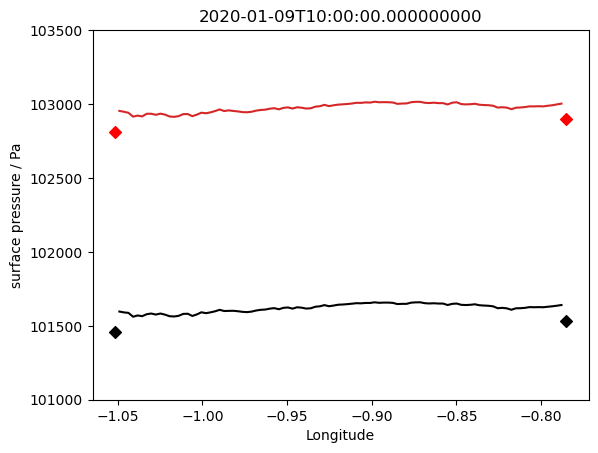

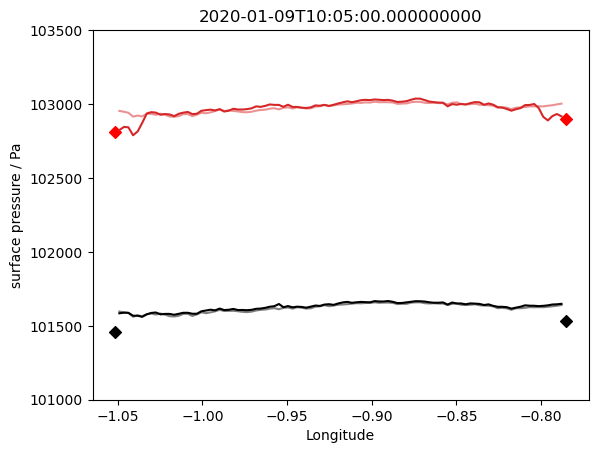

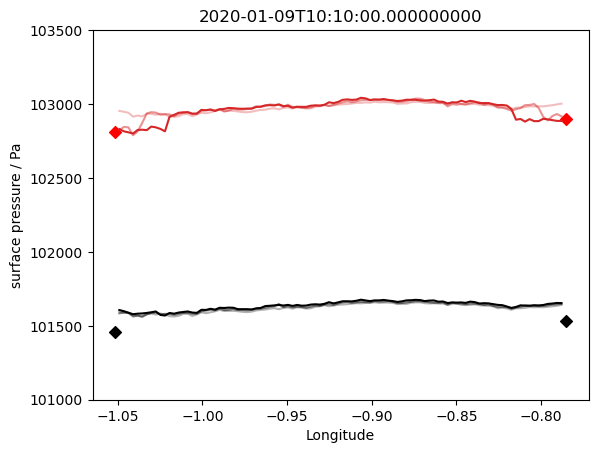

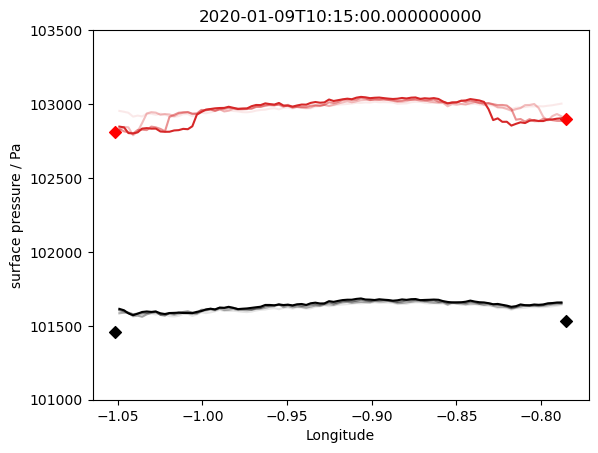

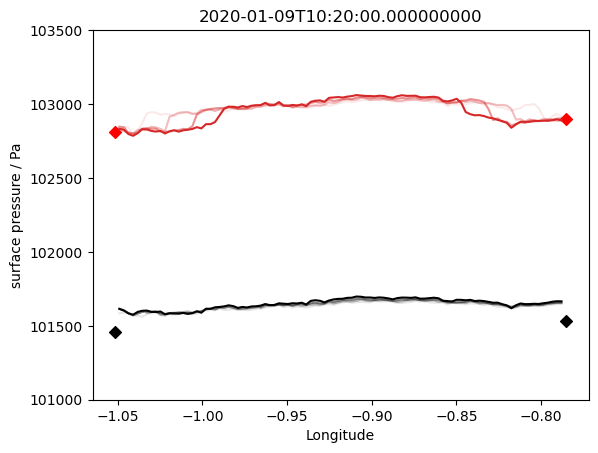

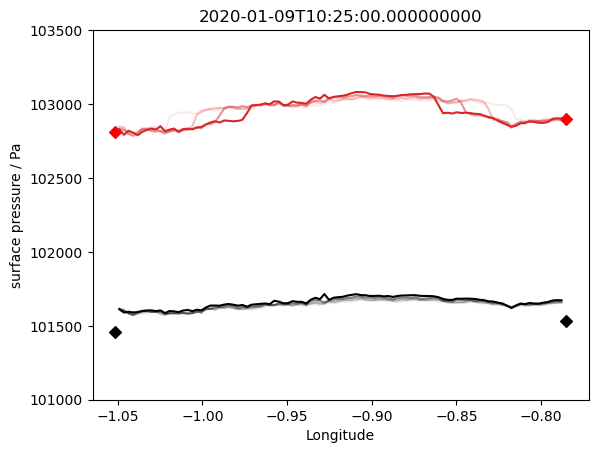

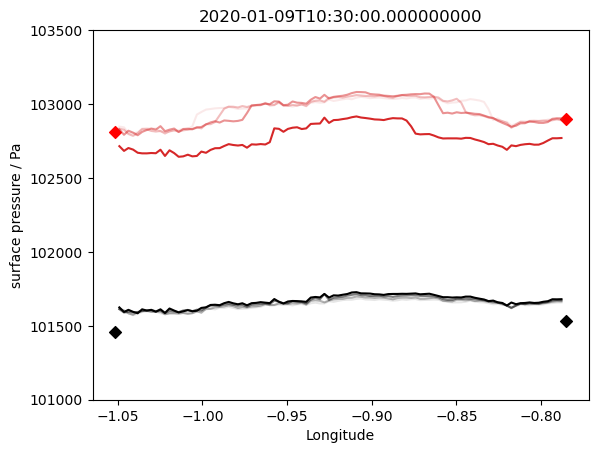

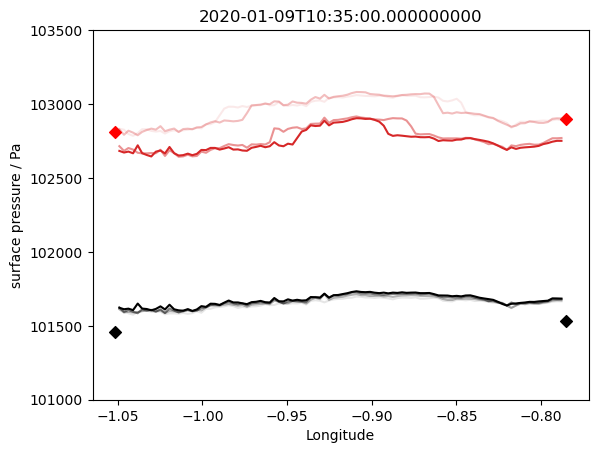

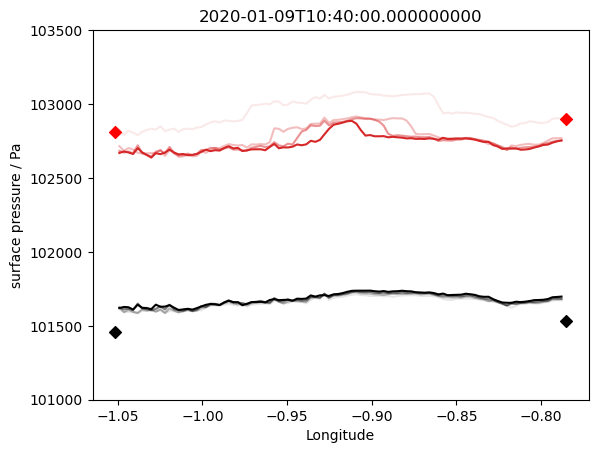

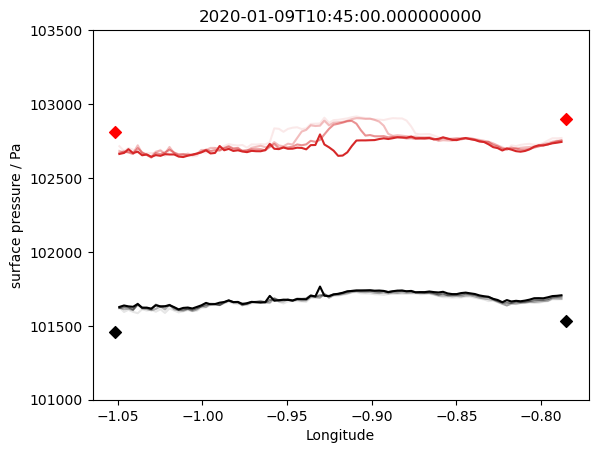

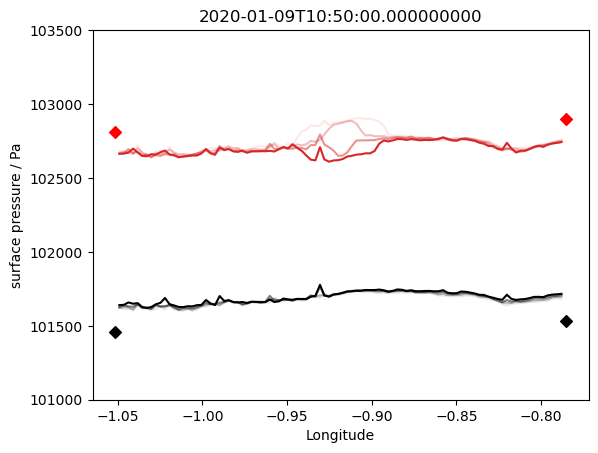

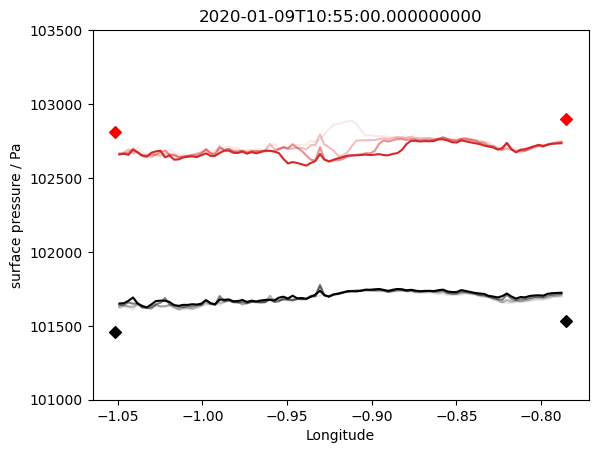

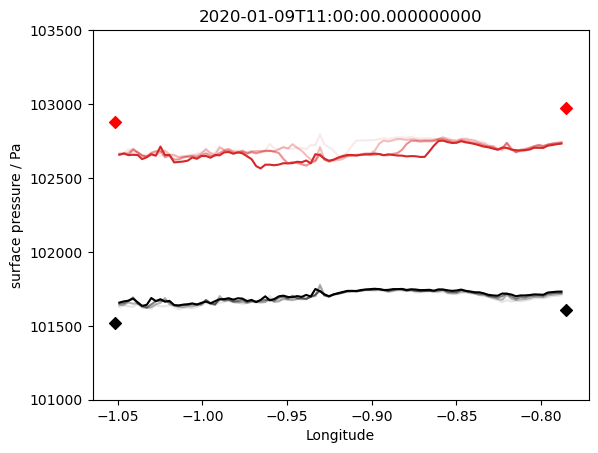

In [11]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import os
import file_handling as fh

import numpy as np
import xarray as xr
import pandas as pd
import postprocessing as pp
import calculations as cc
import matplotlib.pyplot as plt

def matching_boundary_conditions(timestep, path='/work/mh1126/m300872/unchanged/latbc/', file_prefix='latbc_EUREC4A_PR1250m_DOM01_'):
    timestamp = pd.to_datetime(timestep)
    filename = os.path.join(path, timestamp.strftime('%Y%m%d'), f"{file_prefix}{timestamp.strftime('%Y%m%d%H')}.nc")
    dataset = xr.open_dataset(filename)
    dataset = pp.clean_volume_data(dataset, convert_time=False)
    return xr.open_dataset(filename)

def ax_longitudinal_section(ax, data, var, kwargs={}):
    lon = np.linspace(*cc.minmax(data.lon), 100)
    lat = np.ones(100) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax

def fig_compare_longitudinal_sections(varname='t_2m', time_index=12):
    fig, ax = plt.subplots()
    
    path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'
    data = fh.disk_data_from_keywords(path, ['surface','DOM01'])
    data = pp.clean_surface_data(data)
    data = data.isel(time=time_index)
    data = pp.add_grid(data)
    timestep = data.time.values
    ax = ax_longitudinal_section(ax, data, varname, {'color':'tab:red', 'label':'warming'})

    data = fh.eureca_data_from_keywords(['surface','DOM01'])
    data = data.sel(time=timestep)
    data = pp.add_grid(data)
    ax = ax_longitudinal_section(ax, data, varname, {'color':'black', 'label':'control'})
    
    alpha = .5
    for i in range(3):
        if not time_index == 0:
            # path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_04'
            data = fh.disk_data_from_keywords(path, ['surface','DOM01'])
            data = pp.clean_surface_data(data)
            data = data.isel(time=(time_index - 1))
            data = pp.add_grid(data)
            timestep = data.time.values
            ax = ax_longitudinal_section(ax, data, varname, {'color':'tab:red', 'label':None, 'alpha':alpha})

            data = fh.eureca_data_from_keywords(['surface','DOM01'])
            data = data.sel(time=timestep)
            data = pp.add_grid(data)
            ax = ax_longitudinal_section(ax, data, varname, {'color':'black', 'label':None, 'alpha':alpha})
            time_index -= 1
            alpha -= .2
    return fig, ax

def ax_longitudinal_section_boundaries(ax, data, var, kwargs={}):
    lon = np.linspace(*cc.minmax(data.lon), 100)
    lat = np.ones(100) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax

def fig_lon_crosssection_boundaries(varnames={'2d':'pres_sfc', '3d':'pres'}, timestep=0):
    fig, ax = fig_compare_longitudinal_sections(varnames['2d'], timestep)
    ax.set_ylim(101000, 103500)
    
    bc_path = '/work/mh1126/m300872/unchanged/latbc/'
    kwargs = {'label':'control boundary conditions', 'color':'black', 'marker':'D'}
    path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'
    data = fh.disk_data_from_keywords(path, ['surface','DOM01'])
    data = pp.clean_surface_data(data)
    timestamp = data.isel(time=timestep).time.values
    data = matching_boundary_conditions(timestamp, path=bc_path)
    data = pp.clean_volume_data(data, convert_time=0)
    data = pp.add_grid(data, grid_path=os.path.join(bc_path, 'lateral_boundary_DOM01.grid.nc'))
    dim = [d for d in data[varnames['3d']].dims if d not in ['time','cell']][0]
    data = data.isel({ dim : len(data[dim])-1 })
    lon = np.asarray(cc.minmax(data.lon))
    lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.scatter(data.lon.values, data[varnames['3d']].values, **kwargs)
    
    bc_path = '/work/mh1126/m300872/moist_adiabatic_rhofix/latbc/'
    kwargs = {'label':'warming boundary conditions', 'color':'red', 'marker':'D'}
    data = matching_boundary_conditions(timestamp, path=bc_path)
    data = pp.clean_volume_data(data, convert_time=0)
    data = pp.add_grid(data, grid_path=os.path.join(bc_path, 'lateral_boundary_DOM01.grid.nc'))
    dim = [d for d in data[varnames['3d']].dims if d not in ['time','cell']][0]
    data = data.isel({ dim : len(data[dim])-1 })
    lon = np.asarray(cc.minmax(data.lon))
    lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.scatter(data.lon.values, data[varnames['3d']].values, **kwargs)

    ax.set_title(timestamp)
    return fig, ax

for i in range(13):
    fig, ax = fig_lon_crosssection_boundaries(timestep=i)
    output_path = f'/scratch/m/m300872/crosssection/crosssection_{i:02d}.png'
    fig.savefig(output_path)
    print(output_path)
fig.show()

In [18]:
import imageio
import glob

def video_from_snapshots(files, save_path, fps=12, verbose=True): 
    '''Concats frames from images in a file list and save video to path.'''
    # use fps=6 for shorter videos
    writer = imageio.get_writer(save_path, fps=fps)
    for im in files: writer.append_data(imageio.imread(im))
    writer.close()
    if verbose: print(f'{save_path} DONE')

def make_video():
    output_path = f'/scratch/m/m300872/crosssection/' #crosssection_{i}.png'
    files = fh.list_files(output_path, full_path=True)
    for f in (files): print(f)
    video_filename = f'/home/m/m300872/warm_eurec4a/03_adiabatic_warming/pressure_crosssection.mp4'
    video_from_snapshots(files, video_filename, fps=2)
    return video_filename

make_video()

/scratch/m/m300872/crosssection/./crosssection_00.png
/scratch/m/m300872/crosssection/./crosssection_01.png
/scratch/m/m300872/crosssection/./crosssection_02.png
/scratch/m/m300872/crosssection/./crosssection_03.png
/scratch/m/m300872/crosssection/./crosssection_04.png
/scratch/m/m300872/crosssection/./crosssection_05.png
/scratch/m/m300872/crosssection/./crosssection_06.png
/scratch/m/m300872/crosssection/./crosssection_07.png
/scratch/m/m300872/crosssection/./crosssection_08.png
/scratch/m/m300872/crosssection/./crosssection_09.png
/scratch/m/m300872/crosssection/./crosssection_10.png
/scratch/m/m300872/crosssection/./crosssection_11.png
/scratch/m/m300872/crosssection/./crosssection_12.png
/home/m/m300872/warm_eurec4a/03_adiabatic_warming/pressure_crosssection.mp4 DONE


/tmp/ipykernel_2263509/3455056845.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  for im in files: writer.append_data(imageio.imread(im))


'/home/m/m300872/warm_eurec4a/03_adiabatic_warming/pressure_crosssection.mp4'

In [62]:

# plots[0].set({'color':'blue'})
type(fig)

matplotlib.figure.Figure

In [30]:




# files = fh.list_files(path, ['PR1250m'], full_path=True)
    # dataset = xr.open_mfdataset(files)
    # dataset = dataset.isel(time=timestep)
    # # dataset = dataset.mean(dim=['ncells'], keep_attrs=True)
    # dataset = dataset.rename({'ncells':'cell'})
    # # dataset = pp.add_grid(dataset, grid_path=os.path.join(path,'lateral_boundary_DOM01.grid.nc'))
    # return dataset

# print(open_boundary_conditions(path='/work/mh1126/m300872/unchanged/latbc/', timestep=0).time.values)

open_boundary_conditions(timestep)

array(['2020-01-09T10:00:00.000000000'], dtype='datetime64[ns]')

In [1]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)
import xarray as xr
import file_handling as fh
import postprocessing as pp

def matching_boundary_conditions(timestep, path='/work/mh1126/m300872/unchanged/latbc/', file_prefix='latbc_EUREC4A_PR1250m_DOM01_'):
    timestamp = pd.to_datetime(timestep)
    filename = os.path.join(path, timestamp.strftime('%Y%m%d'), f"{file_prefix}{timestamp.strftime('%Y%m%d%H')}.nc")
    dataset = xr.open_dataset(filename)
    dataset = pp.clean_volume_data(dataset, convert_time=False)
    return xr.open_dataset(filename)

path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_04'
data = fh.disk_data_from_keywords(path, ['surface','DOM01'])
data = pp.clean_surface_data(data)
data = pp.add_grid(data)
for timestep in data.time.values:
    print(timestep, matching_boundary_conditions(timestep).time.values)

NameError: name 'pd' is not defined

In [ ]:
import pandas as pd

path='/work/mh1126/m300872/unchanged/latbc/'
files = fh.list_files(path, ['PR1250m'], full_path=True)
print(files[0])

timestamp='2020-01-08T01:00:00.000000000'
t = pd.to_datetime(timestamp)
t.strftime('%Y%m%d'), t.strftime('%Y%m%d%H')

In [ ]:
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)
# import os
import file_handling as fh
import xarray as xr

def open_boundary_conditions(path='/work/mh1126/m300872/unchanged/latbc/', timestep=0):
    files = fh.list_files(path, ['PR1250m'], full_path=True)
    dataset = xr.open_mfdataset(files)
    dataset = dataset.isel(time=timestep)
    # dataset = dataset.mean(dim=['ncells'], keep_attrs=True)
    dataset = dataset.rename({'ncells':'cell'})
    dataset = pp.add_grid(dataset, grid_path=os.path.join(path,'lateral_boundary_DOM01.grid.nc'))
    return dataset

path='/work/mh1126/m300872/unchanged/latbc/'
files = fh.list_files(path, ['PR1250m'], full_path=True)
dataset = xr.open_mfdataset(files)
dataset.time

In [ ]:
def open_boundary_conditions(path='/work/mh1126/m300872/unchanged/latbc/', timestep=0):
    files = fh.list_files(path, ['PR1250m'], full_path=True)
    dataset = xr.open_mfdataset(files)
    dataset = dataset.isel(time=timestep)
    # dataset = dataset.mean(dim=['ncells'], keep_attrs=True)
    dataset = dataset.rename({'ncells':'cell'})
    dataset = pp.add_grid(dataset, grid_path=os.path.join(path,'lateral_boundary_DOM01.grid.nc'))
    return dataset


In [ ]:
import os
path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/'
os.listdir(path)

In [26]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import xarray as xr
import calculations as cc
import postprocessing as pp
import numpy as np

import importlib
importlib.reload(cc)

import inspect
def print_source(foo):
    lines = inspect.getsource(foo)
    print(lines)

def open_initc(path='/work/mh1126/m300872/unchanged/initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc'):
    dataset = xr.open_dataset(path).isel(time=0)
    dataset = pp.clean_volume_data(dataset, convert_time=0)
    drop_vars = ['clon_bnds', 'clat_bnds', 'elon_bnds', 'elat_bnds', 'height_bnds', 'height_2_bnds', 'depth_bnds', 'vn']
    dataset = dataset.drop_vars(drop_vars)
    dataset = dataset.drop_dims(['ncells_2'])
    dataset = cc.replace_level_with_height(dataset)
    dataset = dataset.mean(dim=['cell'], keep_attrs=True)
    return dataset

def initc_diff_to_hydrostatic(path='/work/mh1126/m300872/unchanged/initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc'):
    initc = open_initc(path)
    p = np.flip(initc['p'].values)
    h = np.flip(initc['height'].values)
    p_calc = cc.hydrostatic_profile(h, p_surf=p[0])
    return p_calc, p, h

print_source(cc.hydrostatic_profile)
print('\n\n###########################################################################\n\n')
for p_calc, p, h in zip(*initc_diff_to_hydrostatic()): print(f'{h: 8.2f} {p_calc: 10.2f} {p: 10.2f}')

def hydrostatic_profile(h, p_surf=100000):
    """
    Calculates the hydrostatic profile of pressure given an array of heights. 
    
    Calculates stepwise from the surface assuming a standard atmosphere, using 
    [`mpcalc.add_height_to_pressure`](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.add_height_to_pressure.html).

    Args:
        h (numpy.array): Array of heights im meter.
        p_surf (float, optional): Surface pressure in Pascal. Defaults to 100000.

    Returns:
        numpy.array: Hydrostatic pressure profile.
        
    Notes:
        Standard atmosphere reference: United States. National Oceanic, Atmospheric Administration, & United States. Air Force. (1976). US Standard Atmosphere, 1976 (Vol. 76, No. 1562). National Oceanic and Atmospheric Administration.
    """
    p = np.zeros(len(h))
    p[0] = p_surf
    print(f'{"height":>8} {"d_height":>12} {"d_p":>12}  {"pressure":>11} {"calc":>11}')
    for i in range(1,len(p)):
        pressure = 

In [ ]:
def interpolate_full_level(half_level):
    return np.asarray([(half_level[i]+half_level[i-1])/2 for i in range(1,len(half_level))])

# def get_z_full(z_ifc=False):
#     if not z_ifc:
#         cat = eurec4a.get_intake_catalog()['simulations']['grids']
#         d = cat['ecf22d17-dcee-1510-a807-11ae4a612be0'].to_dask()
#         d = d.isel(cell=0)
#         z_ifc = np.flip(d['z_ifc'].values)
#     z_full = interpolate_full_level(z_ifc)
#     return np.flip(z_full)

# THIS STILL HAS PROBLEMS!!!!
def get_z_full(z_ifc=None):
    if not z_ifc is not None:
        cat = eurec4a.get_intake_catalog()['simulations']['grids']
        d = cat['ecf22d17-dcee-1510-a807-11ae4a612be0'].to_dask()
        d = d['z_ifc'].median(dim='cell')
        z_ifc = np.flip(d.values)
    z_full = interpolate_full_level(z_ifc)
    return z_full
def add_full_level_height(dataset, varnames=None):
    varnames = add_varnames_to_default(varnames)
    dimnames = dataset[varnames['pressure']].dims
    try:    dataset[varnames['full level height']] = (dimnames, get_z_full(dataset['z_ifc']))
    except: dataset[varnames['full level height']] = (dimnames, get_z_full())
    dataset[varnames['full level height']].assign_attrs(long_name=f'full level height (interpolated)', unit=f'meter')
    return dataset

def replace_level_with_height(data, height_name='height'):
    height = np.flip(get_z_full())
    replacements = height[data[height_name].values.astype(int) -1]
    data = data.assign_coords({height_name : replacements})
    return data
